In [1]:
import os
import numpy as np 
from astropy.io import fits
import astropy.table as atable
import matplotlib.pyplot as plt

In [2]:
from desitarget.sv3.sv3_targetmask import desi_mask as sv3_desi_mask
from desitarget.sv3.sv3_targetmask import bgs_mask as sv3_bgs_mask

In [3]:
exps = atable.Table.read('/global/cfs/cdirs/desi/spectro/redux/daily/tsnr-exposures.fits')

In [4]:
exps[:5]

NIGHT,EXPID,TILEID,SURVEY,FAPRGRM,FAFLAVOR,EXPTIME,EFFTIME_SPEC,GOALTIME,GOALTYPE,MINTFRAC,AIRMASS,EBV,SEEING_ETC,EFFTIME_ETC,TSNR2_ELG,TSNR2_QSO,TSNR2_LRG,TSNR2_LYA,TSNR2_BGS,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,TRANSPARENCY_GFA,SEEING_GFA,FIBER_FRACFLUX_GFA,FIBER_FRACFLUX_ELG_GFA,FIBER_FRACFLUX_BGS_GFA,FIBERFAC_GFA,FIBERFAC_ELG_GFA,FIBERFAC_BGS_GFA,AIRMASS_GFA,SKY_MAG_AB_GFA,SKY_MAG_G_SPEC,SKY_MAG_R_SPEC,SKY_MAG_Z_SPEC,EFFTIME_GFA,EFFTIME_DARK_GFA,EFFTIME_BRIGHT_GFA,EFFTIME_BACKUP_GFA
int32,int32,int32,bytes7,bytes19,bytes19,float64,float64,float64,bytes7,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
20200219,50986,63075,unknown,unknown,unknown,60.0,0.0,0.0,unknown,0.9,1.043362,0.0942080095410347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20200219,50988,70004,unknown,unknown,unknown,900.0,680.3945587158203,0.0,unknown,0.9,1.104283,0.04696561396121979,0.0,0.0,79.11564636230469,19.950475692749023,54.666229248046875,57.56499099731445,5267.74755859375,680.3945587158203,737.484658203125,522.6901182556153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.955594041629173,21.284226418609467,19.790755796726657,0.0,0.0,0.0,0.0
20200219,50991,63075,unknown,unknown,unknown,60.0,0.0,0.0,unknown,0.9,1.008076,0.0942080095410347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20200219,50995,70004,unknown,unknown,unknown,900.0,846.9120193481444,0.0,unknown,0.9,1.034227,0.04696561396121979,0.0,0.0,98.47814178466797,24.324670791625977,67.42870330810547,66.30667877197266,6406.125,846.9120193481444,896.8575000000001,602.0646432495117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.966302914201346,21.262359707846763,19.752054491279942,0.0,0.0,0.0,0.0
20200219,51001,70004,unknown,unknown,unknown,900.0,999.3838150024413,0.0,unknown,0.9,1.022479,0.04696561396121979,0.0,0.0,116.2074203491211,28.303956985473633,77.67794036865234,71.61495208740234,7325.822265625,999.3838150024413,1025.6151171875001,650.2637649536133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.00288157116244,21.356993054425978,19.844414121595623,0.0,0.0,0.0,0.0


In [5]:
is_bright = exps['FAFLAVOR']  == 'sv3bright'
print('%i sv3bright exposures' % np.sum(is_bright))    
bgs_exps = exps[is_bright]

bgs_exps['TILEID', 'NIGHT', 'EXPID', 'EXPTIME', 'BGS_EFFTIME_BRIGHT', 'SKY_MAG_AB_GFA', 'TRANSPARENCY_GFA', 'SEEING_GFA']

101 sv3bright exposures


TILEID,NIGHT,EXPID,EXPTIME,BGS_EFFTIME_BRIGHT,SKY_MAG_AB_GFA,TRANSPARENCY_GFA,SEEING_GFA
int32,int32,int32,float64,float64,float64,float64,float64
12,20210405,83522,1087.2236328125,1.8642935371398928,20.185822131786963,0.0737075747920858,1.275104114333336
39,20210405,83526,491.12127685546875,217.55007080078127,20.857570201417026,1.1150729027807396,1.3307073248047079
66,20210405,83527,572.2549438476562,184.10497314453127,20.869874103784944,1.0596612536708114,1.4833729875935777
93,20210405,83528,1080.5513916015625,4.601463928222657,20.129518417713655,0.08323843591651636,1.0393883746134764
120,20210405,83530,881.7928466796875,92.62713256835939,20.650148938302763,0.4310864693182298,1.221698235453344
147,20210405,83533,547.2113647460938,200.75629150390628,20.898330349123732,1.022725691217553,1.3897115356335843
201,20210405,83535,378.2012634277344,202.68981933593753,21.03682289454189,0.9576101600932123,1.1865485656621222
174,20210405,83536,304.0738830566406,215.17150634765628,21.225576557643144,0.974382711538792,1.0766250527900043
228,20210405,83541,620.4656982421875,20.35888305664063,21.04921990333986,0.4121416307332073,1.7957597341264067


In [8]:
def rr_file(tileid, night, i_petal):
    frr = os.path.join('/global/cfs/cdirs/desi/spectro/redux/daily/tiles/', str(tileid), str(night), 'zbest-%i-%i-%i.fits' % (i_petal, tileid, night))
    return frr


def get_zbest(tileid, night, targetclass='bright'): 
    petals = [] 
    for i in range(10): 
        frr = rr_file(tileid, night, i)
        if not os.path.isfile(frr): 
            print('%s does not exist' % frr)
            continue
            
        infile = fits.open(frr)
        zbest = atable.Table(infile['ZBEST'].data)
        fmap = atable.Table(infile['FIBERMAP'].data)
        
        tinfo = fmap['TARGETID', 'TARGET_RA', 'TARGET_DEC', 'FLUX_G', 'FLUX_R',
                'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'FIBERFLUX_G','FIBERFLUX_R', 'FIBERFLUX_Z',
                'PHOTSYS', 'SV3_DESI_TARGET', 'SV3_BGS_TARGET', 'DESI_TARGET',
                'BGS_TARGET', 'FIBERSTATUS']
        tinfo    = atable.unique(tinfo, keys='TARGETID')

        deep     = atable.join(zbest, tinfo, keys='TARGETID', join_type='left')
        assert len(deep) == 500 # fibers per petal

        # bad fibers
        badfiber = ((deep['ZWARN'] & 2**9) != 0) | (deep['FIBERSTATUS'] != 0 ) # no data

        # only keep bgs
        if targetclass == 'bright': 
            is_bgs = (deep['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_BRIGHT']) != 0
        elif targetclass == 'faint': 
            is_bgs = (deep['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_FAINT'])  != 0
        elif targetclass == 'all': 
            is_bgs = ((deep['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_BRIGHT'])  != 0) | ((deep['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_FAINT'])  != 0)
        else:
            raise NotImplementedError

        cuts = ~badfiber & is_bgs # not a bad fiber and is BGS
        
        petals.append(deep[cuts])
        
    return atable.vstack(petals)


def get_zsuccess(tileid, night, targetclass='bright'): 
    ''' get redshift success rate for given exposure
    '''
    # get redrock output for DEEP exposure for BGS_ANY targets
    zb = get_zbest(tileid, night, targetclass=targetclass)
    
    crit_zwarn = (zb['ZWARN'] == 0)
    crit_dchi2 = (zb['DELTACHI2']  > 40.) 
    crit_stype = (zb['SPECTYPE'] != "STAR") # only galaxy spectra
    crit_z_lim = (zb['Z'] > 0.0) & (zb['Z'] < 0.6) # rough BGS redshift limit
    crit_z_err = (zb['ZERR'] < (0.0005 * (1. + zb['Z'])))
    zsuccess = crit_zwarn & crit_dchi2 & crit_z_err
    tsuccess0 = crit_stype 
    tsuccess1 = crit_z_lim 
    return zb, zsuccess, tsuccess0, tsuccess1


def zsuccess_rate(prop, zsuccess_cond, range=None, nbins=20, bin_min=2):
    ''' measure the redshift success rate along with property `prop`
    '''
    h0, bins = np.histogram(prop, bins=nbins, range=range)
    hv, _ = np.histogram(prop, bins=bins, weights=prop)
    h1, _ = np.histogram(prop[zsuccess_cond], bins=bins)
    
    good = h0 > bin_min
    hv = hv[good]
    h0 = h0[good]
    h1 = h1[good]

    wmean = hv / h0 # weighted mean 
    rate = h1.astype("float") / (h0.astype('float') + (h0==0))
    e_rate = np.sqrt(rate * (1 - rate)) / np.sqrt(h0.astype('float') + (h0 == 0))
    return wmean, rate, e_rate


def compile_everything(iexps): 
    _g_mags, _r_mags, _z_mags, _w1_mags, _w2_mags, _r_fibmags, _zss, _tss0, _tss1 = [], [], [], [], [], [], [], [], []
    for bgs_exp in bgs_exps[iexps]: 
        _zbest, _zs, _ts0, _ts1 = get_zsuccess(bgs_exp['TILEID'], bgs_exp['NIGHT'], targetclass='all')

        _g_mags.append(22.5 - 2.5 * np.log10(np.array(_zbest['FLUX_G'].clip(1e-16))))
        _r_mags.append(22.5 - 2.5 * np.log10(np.array(_zbest['FLUX_R'].clip(1e-16))))
        _z_mags.append(22.5 - 2.5 * np.log10(np.array(_zbest['FLUX_Z'].clip(1e-16))))
        _w1_mags.append(22.5 - 2.5 * np.log10(np.array(_zbest['FLUX_W1'].clip(1e-16))))
        _w2_mags.append(22.5 - 2.5 * np.log10(np.array(_zbest['FLUX_W2'].clip(1e-16))))
        _r_fibmags.append(22.5 - 2.5 * np.log10(np.array(_zbest['FIBERFLUX_R'].clip(1e-16))))
        _zss.append(_zs)
        _tss0.append(_ts0)
        _tss1.append(_ts1)        

    g_mags = np.concatenate(_g_mags)
    r_mags = np.concatenate(_r_mags)    
    z_mags = np.concatenate(_z_mags)
    w1_mags = np.concatenate(_w1_mags)
    w2_mags = np.concatenate(_w2_mags)
    r_fibmags = np.concatenate(_r_fibmags)
    zss = np.array(np.concatenate(_zss))
    tss0 = np.array(np.concatenate(_tss0))
    tss1 = np.array(np.concatenate(_tss1))
    return g_mags, r_mags, z_mags, w1_mags, w2_mags, r_fibmags, zss, tss0, tss1

Text(0, 0.5, '# of exposures')

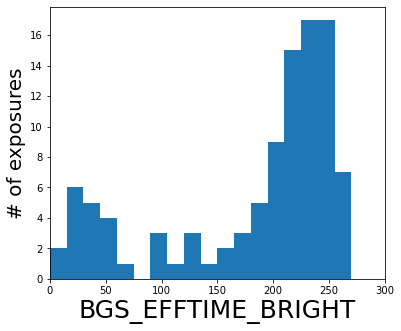

In [10]:
fig = plt.figure(figsize=(6,5))
sub = fig.add_subplot(111)
_ = sub.hist(bgs_exps['BGS_EFFTIME_BRIGHT'], range=(0., 300), bins=20)
sub.set_xlabel('BGS_EFFTIME_BRIGHT', fontsize=25)
sub.set_xlim(0., 300)
sub.set_ylabel('# of exposures', fontsize=20)

/global/cfs/cdirs/desi/spectro/redux/daily/tiles/12/20210405/zbest-5-12-20210405.fits does not exist
/global/cfs/cdirs/desi/spectro/redux/daily/tiles/313/20210417/zbest-8-313-20210417.fits does not exist
/global/cfs/cdirs/desi/spectro/redux/daily/tiles/313/20210417/zbest-9-313-20210417.fits does not exist


(0.6, 1.05)

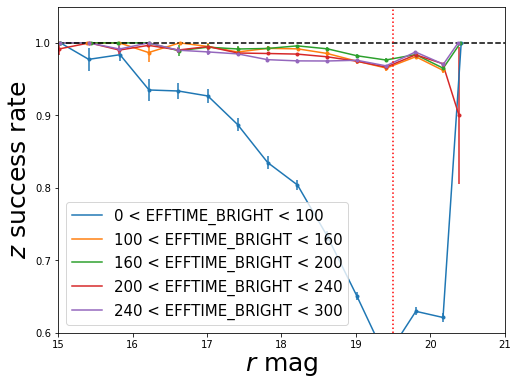

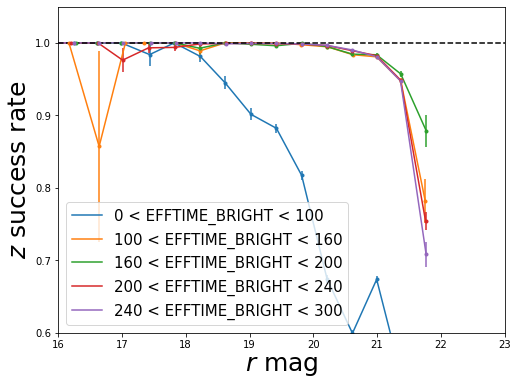

In [11]:
fig1 = plt.figure(figsize=(8,6))
fig2 = plt.figure(figsize=(8,6))
sub1 = fig1.add_subplot(111)
sub2 = fig2.add_subplot(111)
for i, efftime in enumerate([(0., 100.), (100., 160), (160., 200.), (200., 240), (240., 300)]): 
    efftime_range = np.arange(len(bgs_exps))[(bgs_exps['BGS_EFFTIME_BRIGHT'] > efftime[0]) & (bgs_exps['BGS_EFFTIME_BRIGHT'] < efftime[1])]
    
    _, r_mags, _, _, _, r_fibmags, zss, tss0, tss1 = compile_everything(efftime_range)
    tss = tss0 & tss1

    r_mid, zs, zs_err = zsuccess_rate(r_mags, zss, range=(14, 22), nbins=20)
    sub1.errorbar(r_mid, zs, yerr=zs_err, fmt='.C%i' % i)
    sub1.plot(r_mid, zs, c='C%i' % i, label='%.f < EFFTIME_BRIGHT < %.f' % (efftime[0], efftime[1]))
    
    r_mid, zs, zs_err = zsuccess_rate(r_fibmags, zss, range=(14, 22), nbins=20)
    sub2.errorbar(r_mid, zs, yerr=zs_err, fmt='.C%i' % i)
    sub2.plot(r_mid, zs, c='C%i' % i, label='%.f < EFFTIME_BRIGHT < %.f' % (efftime[0], efftime[1]))

sub1.axhline(1., linestyle='--', color='k')
sub1.axvline(19.5, c='r', ls=':')
sub1.legend(loc='lower left', fontsize=15)
sub1.set_xlabel('$r$ mag', fontsize=25)
sub1.set_xlim(15, 21)
sub1.set_ylabel('$z$ success rate', fontsize=25)
sub1.set_ylim(0.6, 1.05)

sub2.axhline(1., linestyle='--', color='k')
sub2.legend(loc='lower left', fontsize=15)
sub2.set_xlabel('$r$ mag', fontsize=25)
sub2.set_xlim(16, 23)
sub2.set_ylabel('$z$ success rate', fontsize=25)
sub2.set_ylim(0.6, 1.05)

In [12]:
efftime_range = np.arange(len(bgs_exps))[(bgs_exps['BGS_EFFTIME_BRIGHT'] > 160) & (bgs_exps['BGS_EFFTIME_BRIGHT'] < 200)]

g_mags, r_mags, z_mags, w1_mags, w2_mags, r_fibmags, zss, tss0, tss1 = compile_everything(efftime_range)
tss = tss0 & tss1

(0.5, 1.05)

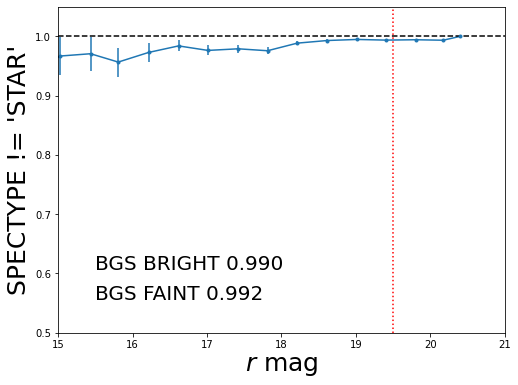

In [13]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
    
r_mid, zs, zs_err = zsuccess_rate(r_mags, tss0, range=(14, 22), nbins=20)
sub.errorbar(r_mid, zs, yerr=zs_err, fmt='.C0')
sub.plot(r_mid, zs, c='C0')
sub.axhline(1., linestyle='--', color='k')

sub.text(15.5, 0.6, 'BGS BRIGHT %.3f' % (np.sum(tss0[r_mags < 19.5])/np.sum(r_mags < 19.5)), ha='left', va='bottom', fontsize=20) 
sub.text(15.5, 0.55, 'BGS FAINT %.3f' % (np.sum(tss0)/len(zss)), ha='left', va='bottom', fontsize=20) 

sub.axvline(19.5, c='r', ls=':')
sub.set_xlabel('$r$ mag', fontsize=25)
sub.set_xlim(15, 21)
sub.set_ylabel("SPECTYPE != 'STAR'", fontsize=25)
sub.set_ylim(0.5, 1.05)

(0.5, 1.05)

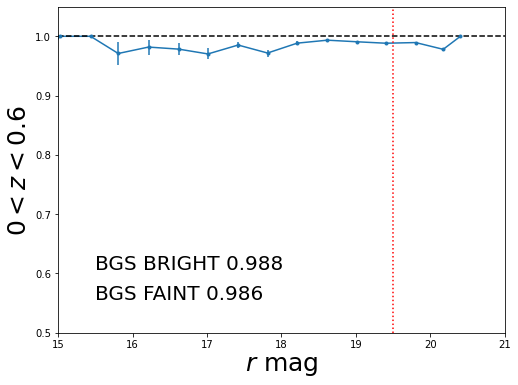

In [14]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
    
r_mid, zs, zs_err = zsuccess_rate(r_mags, tss1, range=(14, 22), nbins=20)
sub.errorbar(r_mid, zs, yerr=zs_err, fmt='.C0')
sub.plot(r_mid, zs, c='C0')
sub.axhline(1., linestyle='--', color='k')

sub.text(15.5, 0.6, 'BGS BRIGHT %.3f' % (np.sum(tss1[r_mags < 19.5])/np.sum(r_mags < 19.5)), ha='left', va='bottom', fontsize=20) 
sub.text(15.5, 0.55, 'BGS FAINT %.3f' % (np.sum(tss1)/len(zss)), ha='left', va='bottom', fontsize=20) 

sub.axvline(19.5, c='r', ls=':')
sub.set_xlabel('$r$ mag', fontsize=25)
sub.set_xlim(15, 21)
sub.set_ylabel('$0 < z < 0.6$', fontsize=25)
sub.set_ylim(0.5, 1.05)

(0.5, 1.05)

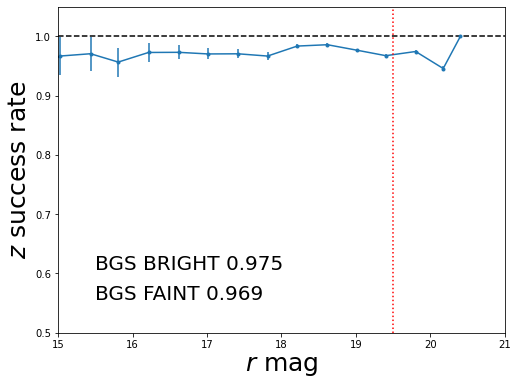

In [15]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
    
r_mid, zs, zs_err = zsuccess_rate(r_mags, zss & tss, range=(14, 22), nbins=20)
sub.errorbar(r_mid, zs, yerr=zs_err, fmt='.C0')
sub.plot(r_mid, zs, c='C0')
sub.axhline(1., linestyle='--', color='k')

sub.text(15.5, 0.6, 'BGS BRIGHT %.3f' % (np.sum((zss & tss)[r_mags < 19.5])/np.sum(r_mags < 19.5)), ha='left', va='bottom', fontsize=20) 
sub.text(15.5, 0.55, 'BGS FAINT %.3f' % (np.sum(zss & tss)/len(zss)), ha='left', va='bottom', fontsize=20) 

sub.axvline(19.5, c='r', ls=':')
sub.set_xlabel('$r$ mag', fontsize=25)
sub.set_xlim(15, 21)
sub.set_ylabel('$z$ success rate', fontsize=25)
sub.set_ylim(0.5, 1.05)

(0.5, 1.05)

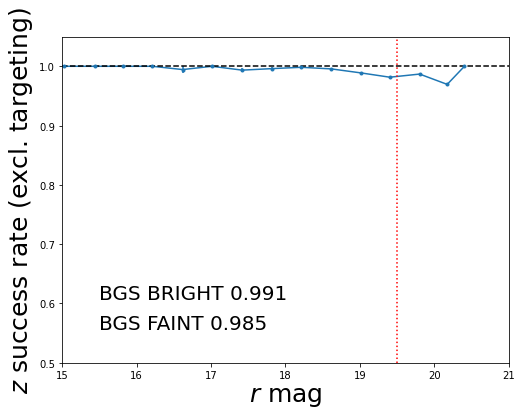

In [16]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
    
r_mid, zs, zs_err = zsuccess_rate(r_mags[tss], zss[tss], range=(14, 22), nbins=20)
sub.errorbar(r_mid, zs, yerr=zs_err, fmt='.C0')
sub.plot(r_mid, zs, c='C0')
sub.axhline(1., linestyle='--', color='k')

sub.text(15.5, 0.6, 'BGS BRIGHT %.3f' % (np.sum((zss & tss)[r_mags < 19.5])/np.sum(tss & (r_mags < 19.5))), ha='left', va='bottom', fontsize=20) 
sub.text(15.5, 0.55, 'BGS FAINT %.3f' % (np.sum(zss & tss)/np.sum(tss)), ha='left', va='bottom', fontsize=20) 

sub.axvline(19.5, c='r', ls=':')
sub.set_xlabel('$r$ mag', fontsize=25)
sub.set_xlim(15, 21)
sub.set_ylabel('$z$ success rate (excl. targeting)', fontsize=25)
sub.set_ylim(0.5, 1.05)

Text(0.5, 0.98, '160 < EFFTIME_BRIGHT < 200')

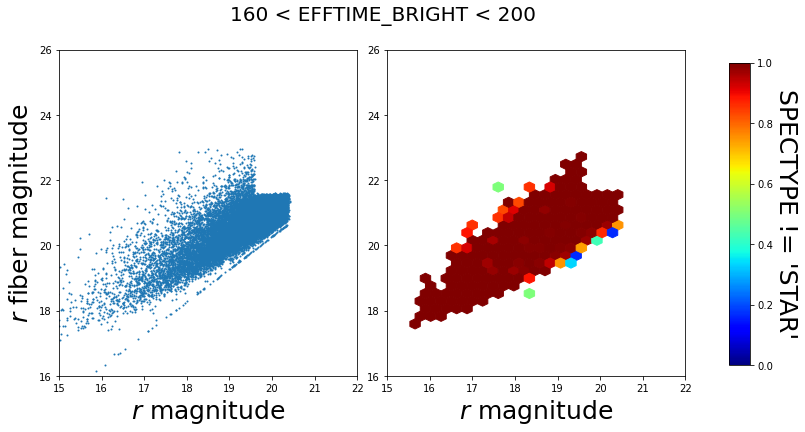

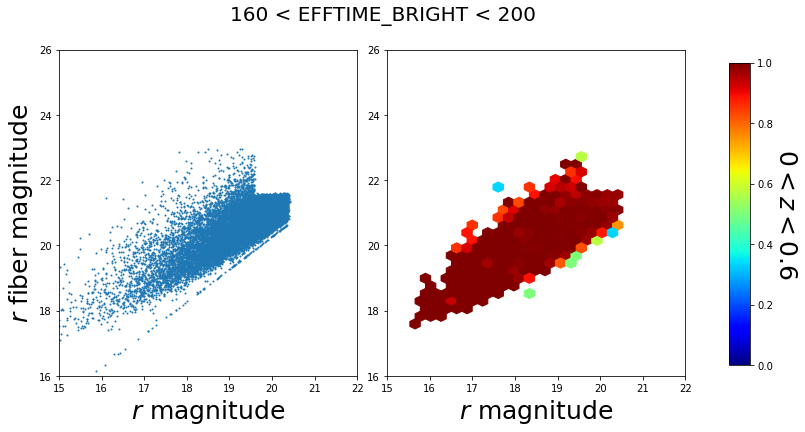

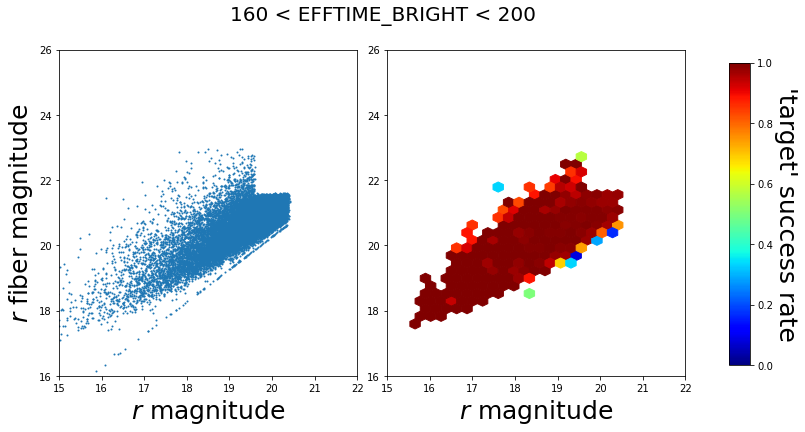

In [17]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)
sub.scatter(r_mags, r_fibmags, c='C0', s=1)
sub.set_xlabel('$r$ magnitude', fontsize=25)
sub.set_xlim(15, 22)
sub.set_ylabel('$r$ fiber magnitude', fontsize=25)
sub.set_ylim(16, 26)

sub = fig.add_subplot(122)
hb = sub.hexbin(r_mags, r_fibmags, C=tss0.astype(float), reduce_C_function=np.mean, gridsize=30, vmin=0., vmax=1., mincnt=5, cmap='jet')

sub.set_xlabel('$r$ magnitude', fontsize=25)
sub.set_xlim(15, 22)
sub.set_ylim(16, 26)
fig.subplots_adjust(wspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r"SPECTYPE != 'STAR'", labelpad=25, fontsize=25, rotation=270)
fig.suptitle("%.f < EFFTIME_BRIGHT < %.f" % (160, 200), fontsize=20)

fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)
sub.scatter(r_mags, r_fibmags, c='C0', s=1)
sub.set_xlabel('$r$ magnitude', fontsize=25)
sub.set_xlim(15, 22)
sub.set_ylabel('$r$ fiber magnitude', fontsize=25)
sub.set_ylim(16, 26)

sub = fig.add_subplot(122)
hb = sub.hexbin(r_mags, r_fibmags, C=tss1.astype(float), reduce_C_function=np.mean, gridsize=30, vmin=0., vmax=1., mincnt=5, cmap='jet')

sub.set_xlabel('$r$ magnitude', fontsize=25)
sub.set_xlim(15, 22)
sub.set_ylim(16, 26)
fig.subplots_adjust(wspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r"$0 < z < 0.6$", labelpad=25, fontsize=25, rotation=270)
fig.suptitle("%.f < EFFTIME_BRIGHT < %.f" % (160, 200), fontsize=20)

fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)
sub.scatter(r_mags, r_fibmags, c='C0', s=1)
sub.set_xlabel('$r$ magnitude', fontsize=25)
sub.set_xlim(15, 22)
sub.set_ylabel('$r$ fiber magnitude', fontsize=25)
sub.set_ylim(16, 26)

sub = fig.add_subplot(122)
hb = sub.hexbin(r_mags, r_fibmags, C=tss.astype(float), reduce_C_function=np.mean, gridsize=30, vmin=0., vmax=1., mincnt=5, cmap='jet')

sub.set_xlabel('$r$ magnitude', fontsize=25)
sub.set_xlim(15, 22)
sub.set_ylim(16, 26)
fig.subplots_adjust(wspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r"'target' success rate", labelpad=25, fontsize=25, rotation=270)
fig.suptitle("%.f < EFFTIME_BRIGHT < %.f" % (160, 200), fontsize=20)

Text(0.5, 0.98, '160 < EFFTIME_BRIGHT < 200')

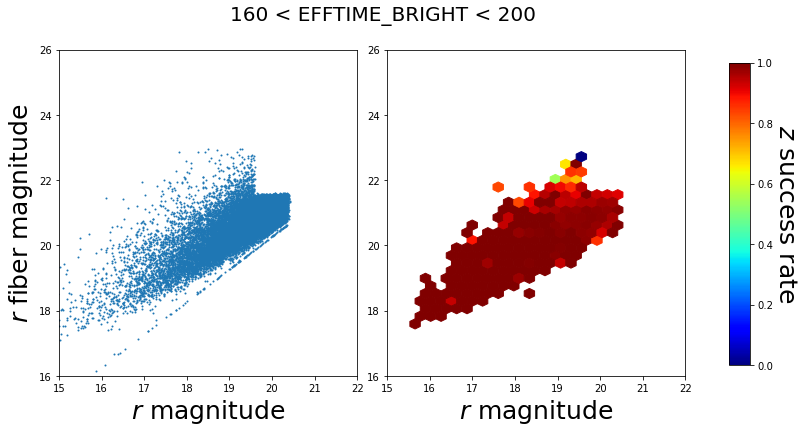

In [18]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)
sub.scatter(r_mags, r_fibmags, c='C0', s=1)
sub.set_xlabel('$r$ magnitude', fontsize=25)
sub.set_xlim(15, 22)
sub.set_ylabel('$r$ fiber magnitude', fontsize=25)
sub.set_ylim(16, 26)

sub = fig.add_subplot(122)
hb = sub.hexbin(r_mags, r_fibmags, C=zss.astype(float), reduce_C_function=np.mean, gridsize=30, vmin=0., vmax=1., mincnt=5, cmap='jet')

sub.set_xlabel('$r$ magnitude', fontsize=25)
sub.set_xlim(15, 22)
sub.set_ylim(16, 26)
fig.subplots_adjust(wspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r'$z$ success rate', labelpad=25, fontsize=25, rotation=270)
fig.suptitle("%.f < EFFTIME_BRIGHT < %.f" % (160, 200), fontsize=20)

In [19]:
schlegel_color = (z_mags - w1_mags) - 3/2.5 * (g_mags - r_mags) + 1.2

Text(0, 0.5, '$z$ success rate')

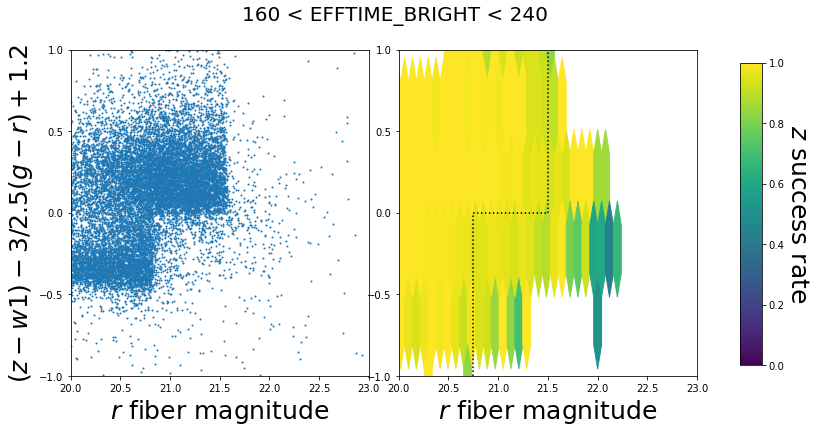

In [20]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)
sub.scatter(r_fibmags, schlegel_color, c='C0', s=1)
sub.set_ylabel('$(z - w1) - 3/2.5 (g - r) + 1.2$', fontsize=25)
sub.set_yticks([-1., -0.5, 0., 0.5, 1.])
sub.set_ylim(-1, 1.)
sub.set_xlabel('$r$ fiber magnitude', fontsize=25)
sub.set_xlim(20, 23)

sub = fig.add_subplot(122)
hb = sub.hexbin(r_fibmags, schlegel_color, C=zss.astype(float), reduce_C_function=np.mean, gridsize=100, vmin=0., vmax=1., mincnt=5)
sub.plot([20.75, 20.75], [-1, 0.], c='k', ls=':')
sub.plot([20.75, 21.5], [0., 0.], c='k', ls=':')
sub.plot([21.5, 21.5], [0., 1.], c='k', ls=':')

sub.set_yticks([-1., -0.5, 0., 0.5, 1.])
sub.set_ylim(-1, 1.)
sub.set_xlabel('$r$ fiber magnitude', fontsize=25)
sub.set_xlim(20, 23)
#sub.set_title("%.f < R_DEPTH_EBVAIR < %.f, MINCNT>5" % (r_depth_ebvair - 0.5 * d_r_depth_ebvair, r_depth_ebvair + 0.5 * d_r_depth_ebvair), fontsize=20)

fig.suptitle("%.f < EFFTIME_BRIGHT < %.f" % (160., 240.), fontsize=20)
fig.subplots_adjust(wspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r'$z$ success rate', labelpad=25, fontsize=25, rotation=270)